In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower')
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/final/experiments/GPs')
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/final/lib')#
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece
import GP_helper


In [4]:
# Return hidden score states 
note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_durations, time_to_next = dict_to_frequency_list(dic)
print(score)

[[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392]

In [5]:
# Create cov_dict
cov_dict = {}
sample_length = 1000
sample_rate = 44100
M=9
T=0.465
v=2.37
sigma_f=5
sigma_n=0.1
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)

for state in score[:20]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = GP_helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=T, v=v) + sigma_n**2 * np.eye(sample_length)

In [6]:
# Create state transmission matrix, T. Here we are using uniform distribution as all notes are the same length

# For now we will go with a very simple uniform distribution to the current or next state
K = len(score[:40]) # The number of states, K
T = np.zeros((K, K)) 
for i in range(K-1): # Populate transition probabilities except final row
    T[i][i], T[i][i+1] = np.log(0.5), np.log(0.5)
T[-1][-1] = 1 # Update final row so transition probability is one, to itself



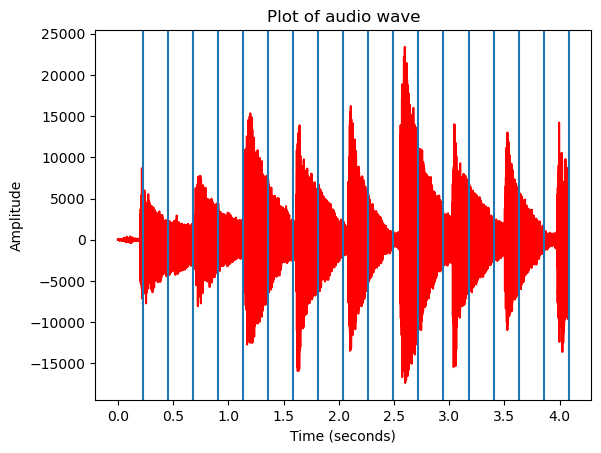

In [48]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 10000
sample_length = 1000
show = 180000
offset = 10000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/final/experiments/data/experiment_wav_files/bach_3.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
GP_helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:18]:
    plt.axvline(i/sample_rate)


In [8]:
def viterbi(y: List[np.ndarray], T: np.ndarray, states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = T.shape[0] # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    
    lml = -GP_helper.stable_nlml(time_samples, y[0], M=9,  f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    gamma[0,0] = 1 * lml # Initialise probability of first audio sample with state 1
    
    # Iterate through the observed audio frames
    for n in range(1, n): # n is the audio frame number
        for k in range(n+1): # Populate the column only up to the max possible state reached
            lml = -GP_helper.stable_nlml(time_samples, y[n], M=9, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
            if k == 0:
                # Case for state 0
                gamma[k, n] = lml + gamma[k, n-1] + T[k,k]
                delta[k, n] = k
            elif k == n:
                gamma[k, n] = lml + gamma[k-1,n-1] + T[k, k-1]
                delta[k, n] = k - 1 # pointer to the previous state
            elif k > 0 and k < n: 
                same_state = lml + gamma[k,n-1] + T[k, k]
                advance_state = lml + gamma[k-1,n-1] + T[ k, k-1]
                if same_state >= advance_state:
                    gamma[k, n] = same_state
                    delta[k, n] = k
                else:
                    gamma[k, n] = advance_state
                    delta[k, n] = k - 1
            else:
                raise(ValueError(f"Unexpected value for k = {k}"))
            
    # Build the output, optimal model trajectory
    s = np.zeros(n, 'B') # 'B' means they are integers
    s[-1] = np.argmax(gamma[:, n-1])

    # Populate s according to the pointers in delta
    for i in reversed(range(1, n)):
        s[i-1] = delta[s[i],i]
    return s, gamma, delta

    # for j in range(no_samples):



s, gamma, delta = viterbi(audio_data[:30], T, score[:30] )
print(gamma[:,-1])

    

[-1.55812294e+13 -1.22667917e+13 -9.25278374e+12 -7.67781902e+12
 -9.68647207e+12 -6.23126727e+12 -4.65630255e+12 -6.66495559e+12
 -8.68512975e+12 -8.12305323e+12 -5.10904526e+12 -3.53408054e+12
 -5.54273358e+12 -2.08752878e+12 -5.12564067e+11 -2.52121711e+12
 -4.54139127e+12 -7.39554579e+12 -8.95827094e+12 -9.59401674e+12
 -1.82579311e+14 -1.65368843e+13 -1.62471854e+13 -1.89232480e+14
 -5.96229336e+13 -6.08157732e+13 -6.10653922e+13 -1.48613204e+14
 -3.21598498e+14 -3.18981606e+14            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf]


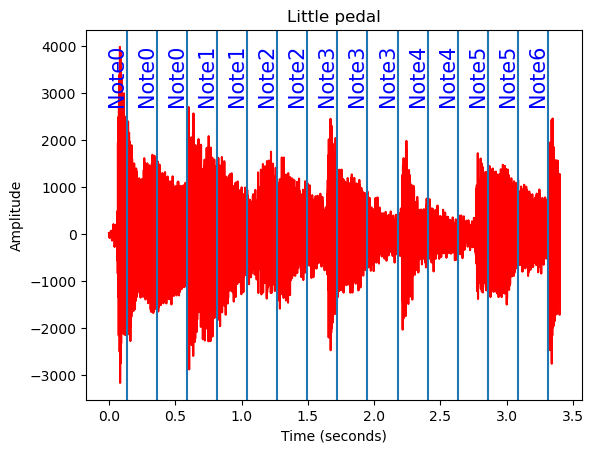

In [25]:
# Plot data to help visualise it
GP_helper.plot_audio(time_samples[:show], data[:show])
plt.title("Little pedal")
for _, i in enumerate(sample_indices[:15]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 2700, f'Note{s[_]}', color='blue', ha='right', va='bottom', rotation=90, fontsize=15)
    

In [18]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_durations, time_to_next = dict_to_frequency_list(dic)
print(score)

[[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392]

In [20]:
# Create cov_dict

cov_dict = {}
sample_length = 1000
sample_rate = 44100
M=9
T=0.465
v=2.37
sigma_f=5
sigma_n=0.1
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)

for state in score[:20]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = GP_helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=T, v=v) + sigma_n**2 * np.eye(sample_length)

In [21]:
# Create state transmission matrix, T. Here we are using uniform distribution as all notes are the same length

# For now we will go with a very simple uniform distribution to the current or next state
K = len(score[:40]) # The number of states, K
T = np.zeros((K, K)) 
for i in range(K-1): # Populate transition probabilities except final row
    T[i][i], T[i][i+1] = np.log(0.5), np.log(0.5)
T[-1][-1] = 1 # Update final row so transition probability is one, to itself



(133679,)


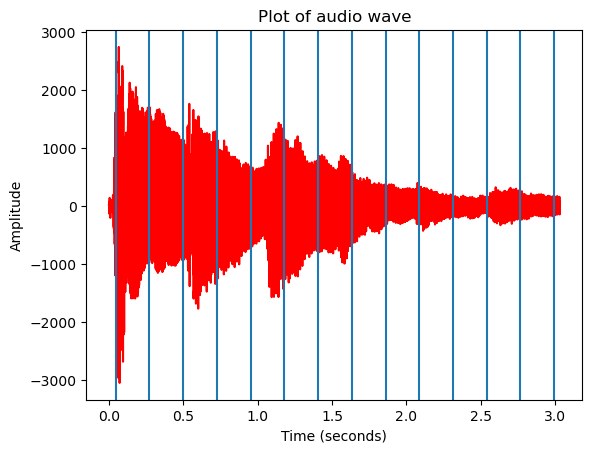

In [25]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 10000
sample_length = 1000
show = 170000
offset = 2000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/piano/prelude_pedal.wav'
sample_rate, data = wav.read(performance_path)
data = data[:]

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
GP_helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:25]:
    plt.axvline(i/sample_rate)
print((data.shape))


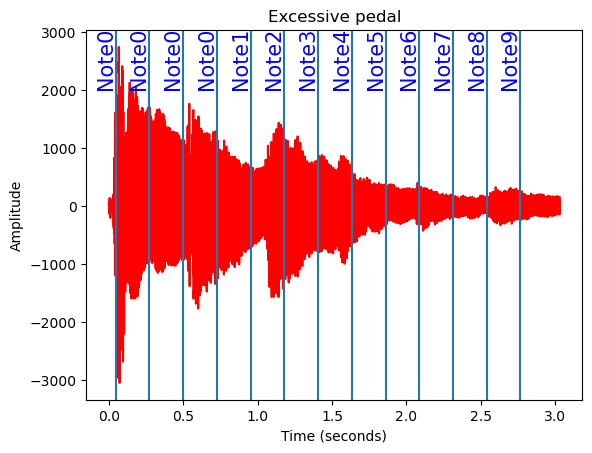

In [32]:
# Plot data to help visualise it
GP_helper.plot_audio(time_samples[:show], data[:show])
plt.title("Excessive pedal")
for _, i in enumerate(sample_indices[:13]):
    plt.axvline((i)/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 2000, f'Note{s[_]}', color='blue', ha='right', va='bottom', rotation=90, fontsize=15)

In [34]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_durations, time_to_next = dict_to_frequency_list(dic)
print(score)

[[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392]

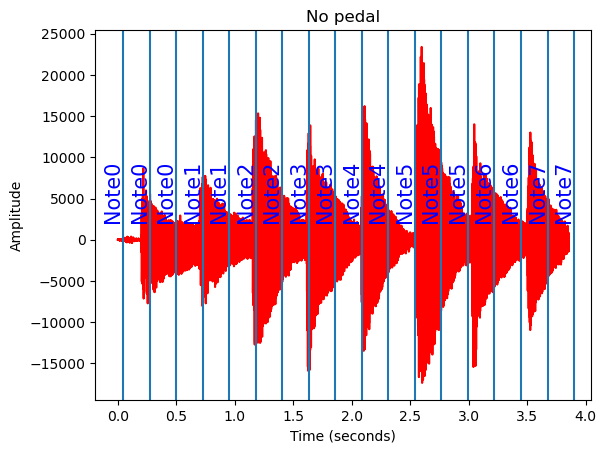

In [45]:
# Plot data to help visualise it
GP_helper.plot_audio(time_samples[:show], data[:show])
plt.title("No pedal")
for _, i in enumerate(sample_indices[:18]):
    plt.axvline((i)/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 2000, f'Note{s[_]}', color='blue', ha='right', va='bottom', rotation=90, fontsize=15)